In [232]:
#Se importan las librerias con las cuales se va a desarrollar el ejercicio

#Manejo de datos
import pandas as pd
import numpy as np
import os
import glob 
import openpyxl

#Gráficos
import seaborn as sns
import matplotlib.pyplot as plt

#ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE 
from xverse.transformer import WOE
from xverse.transformer import MonotonicBinning
from xverse.ensemble import VotingSelector
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score

Creación de funciones personalizadas

In [3]:
## Funciones para valores perdidos.

## Porcentaje de valores perdidos por variable
def resum_missing(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Porcentaje'])
    return missing_data

## dataFrame de resumen de posición de valores perdidos.  
def posmissing(df):
    lista_miss = np.where(df.isna())
    v1 = pd.Series(np.ndarray.tolist(lista_miss[0]))
    v2 = pd.Series(np.ndarray.tolist(lista_miss[1]))
    resumen_vna = pd.concat([v1, v2], axis=1, keys=['posicion_fila', 'posicion_columna'])
    return resumen_vna

In [4]:
# Lee los nombres de archivos del directorio de trabajo
filenames = glob.glob('Datos/*.csv')

In [5]:
filenames

['Datos\\DatosNegativos1.csv', 'Datos\\DatosPositivos1.csv']

In [6]:
# Leemos y cargamos el contenido de los archivos .xlsx
df = pd.DataFrame()
for filename in filenames:
    data = pd.read_csv(filename)
    print(data.shape)
    df = df.append(data)

(5561, 1760)
(8322, 1761)


In [7]:
# Tamaño del set de datos completo
df.shape

(13883, 1761)

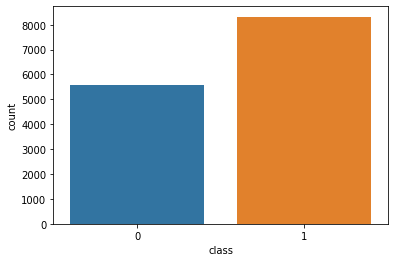

In [8]:
# Contamos los valores por clase, y vemos que la clase está desbalanceada
%matplotlib inline
sns.countplot(df["class"])

Dado que la variable objetivo está desbalanceada, es necesario aplicar un método de balanceo que nos permita tener las clases equilibradas.

In [9]:
# Eliminamos la columna que ennumera del primer archivo
df_dep = df.drop(columns="Unnamed: 0")

In [11]:
# Revisamos si existen registros duplicados
i = 0
for flag in df_dep.duplicated():
    if flag: i+=1
print("Hay ",i," registors duplicados")


Hay  13  registors duplicados


In [12]:
#Se procede a realizar el borrado de los registros duplicados
df_dep.drop_duplicates(inplace = True)

In [13]:
df_dep.shape

(13870, 1760)

In [14]:
df_dep.head()

,sequence,length,molecular_weight,charge,charge_density,isoelectric_point,gravy,instability_index,aromaticity,aliphatic_index,...,embed_2_91,embed_2_92,embed_2_93,embed_2_94,embed_2_95,embed_2_96,embed_2_97,embed_2_98,embed_2_99,class
0,MAATRNK,7,790.93,1.996,0.002524,11.000305,-1.014286,77.657143,0.000000,28.571429,...,0.320600,0.103820,-0.027083,0.252915,0.015264,-0.320885,-0.084070,0.017633,0.048197,0
1,MKMDGLR,7,850.06,0.996,0.001172,8.497986,-0.671429,82.657143,0.000000,55.714286,...,0.465724,-0.162389,-0.067384,0.217970,0.163187,-0.199716,-0.182897,0.005889,0.083639,0
2,MNIKHYQ,7,933.09,1.094,0.001172,8.365906,-1.285714,121.985714,0.142857,55.714286,...,0.079691,-0.089058,-0.164751,0.160001,0.059969,-0.176142,-0.083836,-0.075733,0.013590,0
3,LLWNSIP,7,842.00,-0.004,-0.000005,5.524963,0.757143,55.914286,0.142857,167.142857,...,0.145998,-0.054856,-0.318185,0.192412,-0.221162,-0.243470,-0.044887,-0.169481,0.157881,0
4,MHPHMSY,7,902.05,0.193,0.000214,6.688049,-0.900000,149.057143,0.142857,0.000000,...,0.215792,0.107407,0.015924,0.111517,-0.025620,-0.388453,-0.008939,-0.151773,0.077744,0


In [339]:
# Creamos una columna enumerando cada fila
#df_dep = df_dep.assign(num=[0 + i for i in range(len(df_dep))])[['num'] + df_dep.columns.tolist()]

In [15]:
df_dep.tail()

,sequence,length,molecular_weight,charge,charge_density,isoelectric_point,gravy,instability_index,aromaticity,aliphatic_index,...,embed_2_91,embed_2_92,embed_2_93,embed_2_94,embed_2_95,embed_2_96,embed_2_97,embed_2_98,embed_2_99,class
8317,ILPIIGKILSTIFGK,15,1613.04,1.995,0.001237,10.002747,1.413333,30.873333,0.066667,182.000000,...,0.434125,0.086208,-0.687611,0.073980,0.208663,-0.913782,-0.772072,-0.467112,0.048286,1
8318,YAGAVANDL,9,892.96,-1.004,-0.001124,3.799866,0.522222,25.766667,0.111111,108.888889,...,0.569835,0.000841,-0.218052,0.310862,0.156330,-0.704753,-0.328585,-0.110042,0.144094,1
8319,KKCFRWQWRMKKLGA,15,1966.43,5.927,0.003014,11.172302,-1.166667,36.200000,0.200000,32.666667,...,0.834855,-0.637061,-0.061575,0.375839,0.260569,-1.443030,-0.623450,-0.510046,-0.385037,1
8320,GWAGWLLSPRGSRPSWGP,18,1967.20,1.996,0.001015,12.000061,-0.616667,63.505556,0.166667,48.888889,...,1.342827,0.287493,-0.718676,0.617331,0.311718,-1.982013,-0.189731,-0.301922,-0.016178,1
8321,LRRLYKRVVKLWKRLFRQLRRPVR,24,3237.00,10.994,0.003396,12.480896,-0.858333,129.737500,0.125000,117.500000,...,1.762594,-0.313281,-0.492161,0.683355,0.062932,-2.395024,-0.718505,-0.298672,0.367209,1


In [341]:
# Guardamos las variables num y sequence
#df_1 = df_dep[["num", "sequence"]]
#df_1.tail()

In [16]:
# Eliminamos la variable sequence del dataframe depurado
df_dep.pop("sequence")
df_dep.head()

,length,molecular_weight,charge,charge_density,isoelectric_point,gravy,instability_index,aromaticity,aliphatic_index,boman_index,...,embed_2_91,embed_2_92,embed_2_93,embed_2_94,embed_2_95,embed_2_96,embed_2_97,embed_2_98,embed_2_99,class
0,7,790.93,1.996,0.002524,11.000305,-1.014286,77.657143,0.000000,28.571429,3.387143,...,0.320600,0.103820,-0.027083,0.252915,0.015264,-0.320885,-0.084070,0.017633,0.048197,0
1,7,850.06,0.996,0.001172,8.497986,-0.671429,82.657143,0.000000,55.714286,2.661429,...,0.465724,-0.162389,-0.067384,0.217970,0.163187,-0.199716,-0.182897,0.005889,0.083639,0
2,7,933.09,1.094,0.001172,8.365906,-1.285714,121.985714,0.142857,55.714286,2.180000,...,0.079691,-0.089058,-0.164751,0.160001,0.059969,-0.176142,-0.083836,-0.075733,0.013590,0
3,7,842.00,-0.004,-0.000005,5.524963,0.757143,55.914286,0.142857,167.142857,-1.007143,...,0.145998,-0.054856,-0.318185,0.192412,-0.221162,-0.243470,-0.044887,-0.169481,0.157881,0
4,7,902.05,0.193,0.000214,6.688049,-0.900000,149.057143,0.142857,0.000000,1.165714,...,0.215792,0.107407,0.015924,0.111517,-0.025620,-0.388453,-0.008939,-0.151773,0.077744,0


In [17]:
# Asignamos la variable objetivo
y = df_dep.pop("class")

### Cargamos la data de validación

In [58]:
val_data = pd.read_csv('Datos/val/DatosValidacion1.csv')
val_data.pop("Unnamed: 0")
val_data.pop("Unnamed: 0.1")
val_data.pop("sequence")
y2 = val_data.pop("class")
# Creamos una columna enumerando cada fila
#val_data = val_data.assign(num=[0 + i for i in range(len(val_data))])[['num'] + val_data.columns.tolist()]
val_data.head()

,length,molecular_weight,charge,charge_density,isoelectric_point,gravy,instability_index,aromaticity,aliphatic_index,boman_index,...,embed_2_90,embed_2_91,embed_2_92,embed_2_93,embed_2_94,embed_2_95,embed_2_96,embed_2_97,embed_2_98,embed_2_99
0,33,3897.77,8.691,0.002230,11.404358,-0.112121,84.766667,0.030303,85.757576,3.333939,...,-0.928374,2.771416,-0.851930,-0.459909,0.909622,1.402783,-3.848056,-0.528822,-0.740751,-0.257650
1,34,4003.64,7.590,0.001896,10.196106,-0.638235,76.035294,0.117647,34.411765,3.875588,...,-1.030314,2.356963,-0.590644,-0.433246,0.362768,1.204798,-3.838024,-0.859893,-1.086264,0.052278
2,35,4121.92,6.689,0.001623,9.611023,-0.551429,16.851429,0.057143,64.000000,3.107429,...,-0.846578,2.762231,-1.182640,-0.908285,0.802487,1.546229,-4.543212,-0.786475,-0.477468,-0.178319
3,31,3838.56,6.589,0.001717,9.802917,-0.200000,53.977419,0.161290,47.096774,3.012581,...,-0.960986,1.742604,-0.981736,-0.098695,0.614634,0.774174,-2.818301,-0.395545,-0.738405,0.369630
4,33,3715.45,3.591,0.000967,8.981384,0.660606,62.042424,0.090909,91.212121,1.404848,...,-1.034936,1.734715,-0.830263,-0.386610,0.836167,0.859871,-3.665342,-0.922017,-0.364447,-0.055827


In [59]:
# Normalizamos el set de datos de validación
names = val_data.columns
scaler = preprocessing.StandardScaler()
scaled_val_data = scaler.fit_transform(val_data)
scaled_val_data  = pd.DataFrame(scaled_val_data, columns=names)
scaled_val_data.head()

,length,molecular_weight,charge,charge_density,isoelectric_point,gravy,instability_index,aromaticity,aliphatic_index,boman_index,...,embed_2_90,embed_2_91,embed_2_92,embed_2_93,embed_2_94,embed_2_95,embed_2_96,embed_2_97,embed_2_98,embed_2_99
0,1.200441,1.488957,2.993163,2.041380,1.680420,0.057637,1.795329,-0.751363,-0.178559,1.487591,...,-0.709365,1.945619,-1.703364,0.675871,1.054814,3.373537,-2.357323,0.456880,-0.985170,-1.610517
1,1.346667,1.627166,2.600490,1.720552,1.201197,-0.688985,1.474132,0.681090,-1.690778,1.908721,...,-0.996886,1.241833,-0.840013,0.748034,-0.608378,2.709067,-2.344236,-0.497817,-2.046474,-0.469698
2,1.492893,1.781575,2.279148,1.458301,0.969138,-0.565795,-0.703036,-0.311187,-0.819356,1.311480,...,-0.478661,1.930022,-2.796106,-0.537628,0.728976,3.854966,-3.264137,-0.286104,-0.176447,-1.318507
3,0.907989,1.411661,2.243483,1.548356,1.045248,-0.067074,0.662700,1.396846,-1.317184,1.237736,...,-0.801345,0.198585,-2.132271,1.653474,0.157642,1.263816,-1.014032,0.841203,-0.977964,0.698452
4,1.200441,1.250947,1.174245,0.827828,0.719407,1.154235,0.959383,0.242584,-0.017914,-0.012268,...,-1.009921,0.185188,-1.631771,0.874250,0.831410,1.551430,-2.118977,-0.676961,0.170717,-0.867622


In [60]:
data_val_x = scaled_val_data

## 1- Clasificación sin selección

### 1.1 Normalización

Antes de realizar el particionamiento y balanceo de los datos y aplicar los algoritmos que vamos que trabajaremos para la solución de esta necesidad, es necesario realizar un proceso de normalización, el cual nos permita tener todas las variables en la misma escala.

In [18]:
# Normalizamos el set de datos
names = df_dep.columns
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df_dep)
scaled_df = pd.DataFrame(scaled_df, columns=names)

In [19]:
# Imprimimos los ultimos registros
scaled_df.tail()

,length,molecular_weight,charge,charge_density,isoelectric_point,gravy,instability_index,aromaticity,aliphatic_index,boman_index,...,embed_2_90,embed_2_91,embed_2_92,embed_2_93,embed_2_94,embed_2_95,embed_2_96,embed_2_97,embed_2_98,embed_2_99
13865,-0.488564,-0.642492,-0.020168,0.177404,0.514897,1.607718,-0.197489,-0.446817,1.928100,-1.585107,...,0.154258,-1.146725,1.024871,-0.436728,-1.071036,-0.373448,0.712924,-0.747520,-0.274897,-0.244406
13866,-1.297813,-1.522470,-1.023839,-1.504823,-1.843510,0.670606,-0.314021,-0.009531,0.405997,-0.743800,...,0.897168,-0.926150,0.734878,0.861445,-0.307774,-0.552598,0.973893,0.536071,0.864803,0.148027
13867,-0.488564,-0.210630,1.295748,1.443661,0.959576,-1.105467,-0.075938,0.865040,-1.180876,0.689560,...,1.079754,-0.495402,-1.432091,1.294052,-0.098409,-0.195757,0.052166,-0.317361,-0.411932,-2.019310
13868,-0.083939,-0.209689,-0.019834,0.019127,1.274300,-0.527075,0.547161,0.537076,-0.843145,-0.205060,...,-1.137867,0.330227,1.708642,-0.522612,0.679707,-0.020659,-0.620746,0.937958,0.252357,-0.508451
13869,0.725310,1.342078,2.991513,1.716009,1.457119,-0.781217,2.058540,0.127120,0.585272,1.573250,...,-0.020105,1.012492,-0.332200,0.103627,0.892447,-0.872327,-1.136383,-0.592482,0.262732,1.061913


### 1.2 Creación de particiones

Para el proceso de particionamiento de los datos, manejaremos el set de datos de entrenamiento con un 80% de los datos originales y utilizaremos un 20% para pruebas. Adicionalmente, vamos a utilzar un muestreo donde estratificaremos a partir de la variable objetivo para que al momento de hacer la división se mantenga la distribución de los datos

In [20]:
# Particionamos el set de datos
X_train, X_test, y_train, y_test = train_test_split(scaled_df, y, test_size = .2, random_state=42, stratify = y)
#X_train, X_test, y_train, y_test = train_test_split(scaled_df, y, test_size = .2, random_state=42)

### 1.3 Balanceamos el set de datos

Para realizar el balanceo de los datos, utilizaremos la función SMOTE, la cual es una técnica que nos permitirá hacer un sobre muestreo de la clase minoritaria, en este caso la clase representada con "0", esta función hace parte de la libreria imblearn 

In [21]:
%%time
# Se balancean los datos de entrenamiento
sm = SMOTE(random_state=42)
sm_data_X,sm_data_y=sm.fit_sample(X_train, y_train)

Wall time: 1min 20s


In [22]:
## Convirtiendo en DataFrame
bal_data_X = pd.DataFrame(sm_data_X, columns=X_train.columns)
type(bal_data_X)

pandas.core.frame.DataFrame

In [23]:
bal_data_y = pd.Series(sm_data_y)
type(bal_data_y)

pandas.core.series.Series

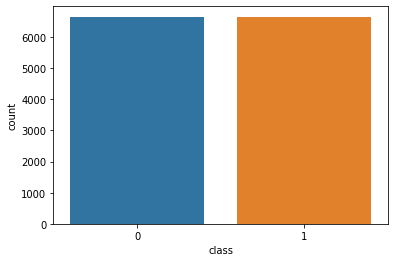

In [24]:
# Revisamos las clases
sns.countplot(bal_data_y)

Se observa que las clases ahora estan balanceadas, ahora podemos aplicar algoritmos de machine learning sin preocuparnos por la perdida de rendimiento a partir de desequilibrio de clases.

### Ahora, construiremos 3 clasificadores a partir de los datos preprocesados y revisaremos su rendimiento

### 1.3.1 Random Forest

In [25]:
# Entrenamos un modelo con Random Forest 
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 5, max_depth=5, random_state=0)
clf.fit(bal_data_X, bal_data_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [26]:
# Aplicamos validación cruzada para evaluar el performance del modelo
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
scores = cross_val_score(clf, bal_data_X, bal_data_y, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.03)


In [27]:
# Hacemos predicciones con la data de prueba
predict = clf.predict(X_test)

In [28]:
predict

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

Text(33.0, 0.5, 'Real')

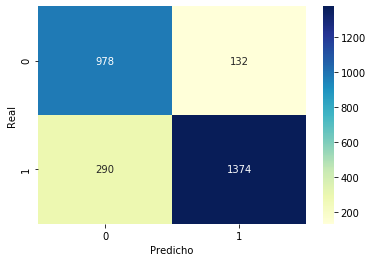

In [29]:
# Revisamos la matriz de confusión
from sklearn.metrics import confusion_matrix
ax = sns.heatmap(confusion_matrix(y_test, predict), annot=True, fmt='', cmap = 'YlGnBu')
bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicho')
plt.ylabel('Real')

In [30]:
# Revisamos otras metricas del modelo
from sklearn.metrics import classification_report
print(classification_report(y_test, predict))

precision    recall  f1-score   support

           0       0.77      0.88      0.82      1110
           1       0.91      0.83      0.87      1664

    accuracy                           0.85      2774
   macro avg       0.84      0.85      0.84      2774
weighted avg       0.86      0.85      0.85      2774



Interpretación de Resultados

Precisión: Se observa que el clasificador etiqueta de buena forma ambas clases, manejando mejor ajuste para la clase "1".

Recall: Vemos que el clasificador tiene muy buena capacidad para encontrar los casos positivos, y vemos que maneja un rendimiento casi igual para ambas clases, siendo mejor para la clase "0".

F1-Score: Encontramos que el clasificador tiene una excelente capacidad de predecir bien los casos positivos. Se puede observar que lo hace mejor manera para la clase "0"

### 1.3.2 Árboles Decisión

Generación del arbol de decisión teniendo en cuenta todas las caracteristicas.

In [226]:
from sklearn.tree import DecisionTreeClassifier
# Crear Arbol de decision con profundidad = 4
decision_tree = DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth = 4,
                                            random_state = 42)

modelo_tree = decision_tree.fit(bal_data_X,bal_data_y)

In [227]:
decision_tree.score(bal_data_X,bal_data_y)

0.8899068789426254

In [228]:
modelo_test = decision_tree.predict(X_test)

In [229]:
print(classification_report(y_test, modelo_test))

precision    recall  f1-score   support

           0       0.86      0.84      0.85      1110
           1       0.90      0.91      0.90      1664

    accuracy                           0.88      2774
   macro avg       0.88      0.88      0.88      2774
weighted avg       0.88      0.88      0.88      2774



In [231]:
# Revisamos la matriz de confusión
confusion_matrix(y_test, modelo_test)

array([[ 935,  175],
       [ 153, 1511]], dtype=int64)

Interpretación de Resultados

Precisión: Se observa que el clasificador etiqueta de excelente forma ambas clases, manejando mejor ajuste para la clase "1".

Recall: Vemos que el clasificador tiene una excelente capacidad para encontrar los casos positivos, y vemos que maneja un rendimiento casi igual para ambas clases, siendo mejor para la clase "1".

F1-Score: Encontramos que el clasificador tiene una excelente capacidad de predecir bien los casos positivos. Nuevamente se puede observar que lo hace mejor manera para la clase "1"

### 1.3.3 Regresión Logística

### Modelo de regresión logística sin ajuste en los hiperparametros

In [233]:
#Definición del modelo de regresión logística con los parámetros por defecto
lr = LogisticRegression(random_state = 1234)

# Entrenamos el modelo con regresión logística sin ajuste en los hiperparametros con los datos de entrenamiento
lr.fit(bal_data_X, bal_data_y)

# Aplicamos validación cruzada para evaluar el performance del modelo
kfold = StratifiedKFold(10) 
# Medidas a evaluar en la validación cruzada
scoring = ['accuracy', 'precision', 'recall', 'f1']

#Aplicamos la validación cruzada con los datos tanto negativos como positivos escalados 
results_woh = cross_validate(lr, scaled_df, y, cv = kfold, scoring = scoring)

print("Accuracy: %.2f%% (+/- %.2f%%)" % (results_woh['test_accuracy'].mean()*100, results_woh['test_accuracy'].std()*100))
print("Precision: %.2f%% (+/- %.2f%%)" % (results_woh['test_precision'].mean()*100, results_woh['test_precision'].std()*100))
print("Recall: %.2f%% (+/- %.2f%%)" % (results_woh['test_recall'].mean()*100, results_woh['test_recall'].std()*100))
print("F1 score: %.2f%% (+/- %.2f%%)" % (results_woh['test_f1'].mean()*100, results_woh['test_f1'].std()*100))

Accuracy: 83.68% (+/- 8.56%)
Precision: 84.64% (+/- 9.96%)
Recall: 91.01% (+/- 1.10%)
F1 score: 87.38% (+/- 5.61%)


Text(33.0, 0.5, 'Real')

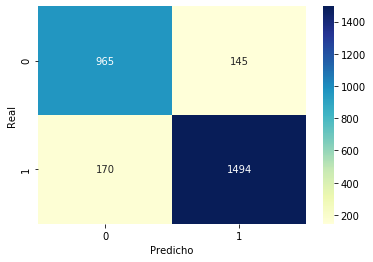

In [234]:
# Hacemos predicciones con la data de prueba
predict_log = lr.predict(X_test)

# Revisamos la matriz de confusión
rlog_cm = confusion_matrix(y_test, predict_log)
sns.heatmap(rlog_cm, fmt='', annot = True, cmap = 'YlGnBu')
plt.xlabel('Predicho')
plt.ylabel('Real')


In [235]:
#Reporte consolidado de la matriz de confusión, a partir de los datos de prueba
print(classification_report(y_test, predict_log))

precision    recall  f1-score   support

           0       0.85      0.87      0.86      1110
           1       0.91      0.90      0.90      1664

    accuracy                           0.89      2774
   macro avg       0.88      0.88      0.88      2774
weighted avg       0.89      0.89      0.89      2774



precision    recall  f1-score   support

           0       0.99      0.45      0.62      1354
           1       0.26      0.97      0.41       269

    accuracy                           0.53      1623
   macro avg       0.62      0.71      0.51      1623
weighted avg       0.87      0.53      0.58      1623



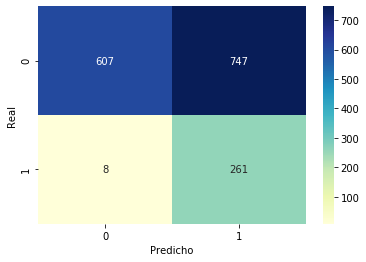

In [236]:
# Se predice con los datos de validación y se genera reporte consolidado de las métricas
predict_logval = lr.predict(scaled_val_data)

sns.heatmap(confusion_matrix(y2, predict_logval), fmt='', annot = True, cmap = 'YlGnBu')
plt.xlabel('Predicho')
plt.ylabel('Real')

print(classification_report(y2, predict_logval))

In [237]:
#Coheficiente Kappa
cohen_kappa_score(y2, predict_logval)

0.19924758228466022

Interpretación de los resultados

Si bien la regresión logística en etapa de entrenamiento y prueba da muy buenos resultados, de un total de 2081 péptidos antimicrobianos que se tenían, el modelo predijo correctamente 2024, representando un 97% de la clase, de igual forma con los péptidos no antimicrobianos donde se tenían en total 1387 péptidos No antimicrobianos y el modelo indicó que efectivamente 1344 no lo eran. Cuando se analiza el modelo con los datos de validación, por su parte, el modelo no tiene un buen desempeño, esto se puede ver en las diferentes métricas generadas, donde todos los porcentajes son inferiores al 30%, esto puede darse porque las clases en este conjunto de datos estan considerablemente desbalanceadas, por el alto número de características que existen y porque los parámetros de la regresión logística que vienen por defecto no son apropiados para las condiciones del dataset.

Adicionalmente, cuando se ve el coeficiente kappa, el cual indica que tan confiable es el modelo, de acuerdo a la tabla de validación del coeficiente, la regresión logística sin ajuste a los hiperparametro, no es confiable.

### Modelo de regresión logística con ajuste en los hiperparametros

In [ ]:
%%time
#Definición de posibles hiperparametros que puede tomar la regresión logística, con esta definicio se pretende utlizar los algoritmos GridSearch y RandomizedSearchCV para determinar que nos ayuden a determinar cuales hiperparametros son los indicados para el modelo
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver = ['liblinear', 'saga', 'sag', 'lbfgs', 'newton-cg']
dual = [True,False]
max_iter = [100,110,120,130,140]

param_grid = dict(penalty = penalty,
                  C = C,
                  solver = solver,
                  dual = dual,
                  max_iter = max_iter)

In [ ]:
grid = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_result = grid.fit(bal_data_X, bal_data_y)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

In [ ]:
#Con randomizedSearchCV
random = RandomizedSearchCV(estimator=lr, param_distributions=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, n_iter = 200)
random_result = random.fit(bal_data_X, bal_data_y)

print('Best Score: ', random_result.best_score_)
print('Best Params: ', random_result.best_params_)

Los dos métodos GridSearchCV y RandomizedSearchCV dan una configuración muy similar: 'solver': 'liblinear', C: 0.001, penalty: l1, dual: False, max_iter: entre 100 y 120. Está configuración con los datos de entrenamiento y prueba dan muy buenos resultados (Recall 97.16%, Precisión 90%, F1 Score 85%, Accuracy 91.69%), pero con los datos de validación, no (Recall 33%, Precisión 56%, F1 Score 42%, Accuracy 33%), por lo cual se procede a realizar iteraciones manuales en busca de un modelo que para los set de datos con los que se cuentan, se comporte un poco mejor.

Accuracy: 82.60% (+/- 5.71%)
Precision: 92.30% (+/- 8.47%)
Recall: 91.01% (+/- 1.10%)
F1 score: 84.60% (+/- 3.98%)


Text(33.0, 0.5, 'Real')

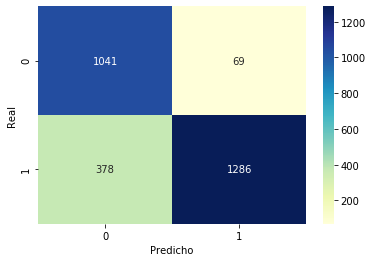

In [238]:
# Se define la regresión logística a partir de los parametros encontrados como óptimos
lr_hyp = LogisticRegression(C = 0.0001, solver = 'liblinear', fit_intercept= False, random_state = 123)

# Entrenamos el modelo con regresión logística
lr_hyp.fit(bal_data_X, bal_data_y)

# Aplicamos validación cruzada para evaluar el performance del modelo
results_why = cross_validate(lr_hyp, scaled_df, y, cv = kfold, scoring = scoring)

#impresión de métricas
print("Accuracy: %.2f%% (+/- %.2f%%)" % (results_why['test_accuracy'].mean()*100, results_why['test_accuracy'].std()*100))
print("Precision: %.2f%% (+/- %.2f%%)" % (results_why['test_precision'].mean()*100, results_why['test_precision'].std()*100))
print("Recall: %.2f%% (+/- %.2f%%)" % (results_woh['test_recall'].mean()*100, results_woh['test_recall'].std()*100))
print("F1 score: %.2f%% (+/- %.2f%%)" % (results_why['test_f1'].mean()*100, results_why['test_f1'].std()*100))

# Hacemos predicciones con la data de prueba
predict_log_hyp = lr_hyp.predict(X_test) 

# Revisamos la matriz de confusión
rlog_cm = confusion_matrix(y_test, predict_log_hyp) #y_test, predict_log_hyp
sns.heatmap(rlog_cm, fmt='', annot = True, cmap = 'YlGnBu')
plt.xlabel('Predicho')
plt.ylabel('Real')

In [239]:
# Revisamos otras metricas del modelo
print(classification_report(y_test, predict_log_hyp))

precision    recall  f1-score   support

           0       0.73      0.94      0.82      1110
           1       0.95      0.77      0.85      1664

    accuracy                           0.84      2774
   macro avg       0.84      0.86      0.84      2774
weighted avg       0.86      0.84      0.84      2774



precision    recall  f1-score   support

           0       0.99      0.68      0.80      1354
           1       0.37      0.95      0.53       269

    accuracy                           0.72      1623
   macro avg       0.68      0.81      0.67      1623
weighted avg       0.88      0.72      0.76      1623



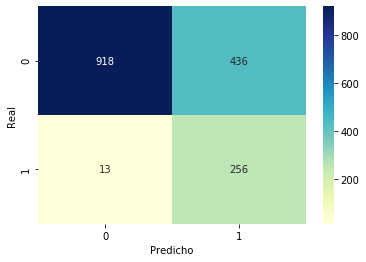

In [240]:
#Se predice el modelo de acuerdo a los datos de validación debidamente escalados
predict_logvalh = lr_hyp.predict(scaled_val_data)

sns.heatmap(confusion_matrix(y2, predict_logvalh), fmt='', annot = True, cmap = 'YlGnBu')
plt.xlabel('Predicho')
plt.ylabel('Real')

print(classification_report(y2, predict_logvalh))

In [241]:
#Coheficiente Kappa
cohen_kappa_score(y2, predict_logvalh)

0.3862870944840312

Interpretación de resultados

Apesar que en esta ejecución sobre los datos de validación mejora con respecto a la ejecución usando los hiperparámetros por defecto, de igual forma se tiene un performance bajo con los datos de validación, el accuracy en este caso es del 43%, lo que quiere decir que del total de datos solo el 43% fue capaz de predecirlo correctamente como péptidos antimicrobiano y péptidos no antimicrobiano. Con respecto a la predicción de los péptidos antimicrobiano sólo los predice en un 21%, caso contrario pasa con los datos de prueba, en donde los péptidos antimicrobiano son predecidos en un 81% los no microbianos en un 96%. En este modelo se vuelve a evidenciar un bajo coeficiente de kappa, concluyendo que el modelo no es confiable

# 2- Clasificación con Selección

## 2.1.1 Selección de Variables

### Buscamos las 100 variables mas importantes usando Random Forest

### RFE Random Forest

In [50]:
rf = RandomForestClassifier(n_estimators = 10, max_depth=5, random_state=42)
rf.fit(bal_data_X, bal_data_y)
mask = rf.feature_importances_ > .01
X_reduced = bal_data_X.loc[:, mask]
print(X_reduced.columns)

Index(['charge_density', 'E', 'M', '_SolventAccessibilityC3', '_ChargeC1',
       '_ChargeC2', '_HydrophobicityC2', '_PolarityT13',
       '_PolarizabilityD1025', '_PolarizabilityD2001', '_PolarizabilityD3001',
       '_SolventAccessibilityD1001', '_SolventAccessibilityD3075',
       '_SecondaryStrD1001', '_SecondaryStrD2025', '_SecondaryStrD3001',
       '_NormalizedVDWVD1001', '_NormalizedVDWVD2001', '_HydrophobicityD2001',
       '_HydrophobicityD3001', 'GearyAuto_FreeEnergy6',
       'GearyAuto_Mutability3', 'QSOgrant13', 'QSOSW12', 'QSOSW13', 'QSOSW27'],
      dtype='object')


## 2.1.2 Extracción de variables usando Peso de la Evidencia y valor de la información

Para encontrar las variables con las que entrenaremos los clasificaremos utilizaremos el Peso de la evidencia y valor de información asi como un sistema de recomendación a partir de modelos de machine learning. La idea es aplicar una variedad de técnicas para seleccionar variables. Cuando un algoritmo elige una variable, le damos un voto. Al final, calculamos los votos totales para cada variable y luego elegimos los mejores en función de los votos. De esta manera, terminamos eligiendo las mejores variables 

In [56]:
%%time
# Seleccionamos las variables mas importantes a partir de votos de modelos
vs = VotingSelector()
vs.fit(bal_data_X, bal_data_y)

Wall time: 40min 58s


VotingSelector(exclude_features=None, feature_names='all',
               handle_category='woe', minimum_votes=0, no_of_features=879,
               numerical_missing_values='median',
               selection_techniques=['WOE', 'RF', 'RFE', 'ETC', 'CS', 'L_ONE'])

In [57]:
delta_crit = 4
priorizadas = vs.feature_votes_[vs.feature_votes_["Votes"]>delta_crit]["Variable_Name"].values
print("Estas son las variables más importantes, según el consenso de votos de selección,", \
      delta_crit+1," donde las columnas de interes son:",\
      priorizadas)

Estas son las variables más importantes, según el consenso de votos de selección, 5  donde las columnas de interes son: ['M' '_ChargeT13' 'GearyAuto_ResidueVol3' 'GearyAuto_ResidueVol10' 'H'
 'GearyAuto_Hydrophobicity15' 'GearyAuto_Hydrophobicity12' 'embed_1_57'
 'GearyAuto_AvFlexibility10' 'GearyAuto_FreeEnergy6' 'embed_0_57'
 '_NormalizedVDWVC3' '_PolarizabilityC3' 'GearyAuto_Hydrophobicity8'
 'GearyAuto_FreeEnergy5' 'embed_2_57' 'GearyAuto_FreeEnergy26' 'Y'
 '_SecondaryStrD2050' '_SecondaryStrD1050' 'molecular_weight' 'embed_1_40'
 'N' 'embed_0_34' 'embed_0_41' 'LL' '_SecondaryStrD2025' 'embed_1_94'
 'embed_2_40' 'MK' '_SecondaryStrD3050' '_HydrophobicityD2100' 'taugrant4'
 'tausw4' '_NormalizedVDWVD1100' 'GearyAuto_Steric12' 'embed_1_93'
 '_PolarizabilityD1025' 'embed_2_82' 'GearyAuto_FreeEnergy19' 'C'
 'QSOSW19' 'MoreauBrotoAuto_Mutability5' 'QSOgrant19' 'embed_2_49'
 '_PolarityD2025' '_HydrophobicityD3025' 'GearyAuto_ResidueVol11'
 'QSOgrant7' 'GearyAuto_FreeEnergy1' 'embed_1_47'

## 2.2 Entrenar con las caracteristicas seleccionadas

## 2.2.1 Random Forest (Validación)

In [221]:
%%time
# Entrenamos un modelo con Random Forest 
rf1=RandomForestClassifier(random_state=42, max_features=.025, n_estimators= 8000, max_depth=1.9, criterion='entropy', min_samples_split = 16,min_samples_leaf = 3, oob_score = True)
rf1.fit(bal_data_X[priorizadas], bal_data_y)
# Hacemos predicciones con la data de prueba
predict1 = rf1.predict(data_val_x[priorizadas])

Wall time: 2min 44s


Text(33.0, 0.5, 'Real')

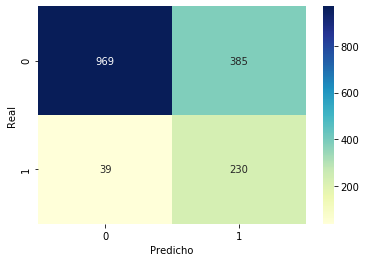

In [122]:
# Revisamos la matriz de confusión
ax = sns.heatmap(confusion_matrix(y2, predict1), annot=True, fmt='', cmap = 'YlGnBu')
bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicho')
plt.ylabel('Real')


In [222]:
print(classification_report(y2, predict1))

precision    recall  f1-score   support

           0       0.96      0.72      0.82      1354
           1       0.37      0.85      0.52       269

    accuracy                           0.74      1623
   macro avg       0.67      0.78      0.67      1623
weighted avg       0.86      0.74      0.77      1623



In [223]:
cohen_kappa_score(y2, predict1)

0.37622693659044515

In [224]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y2, predict1)

0.7842177658926051

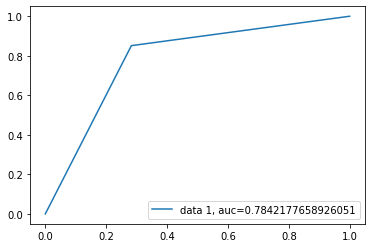

In [225]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y2, predict1)
auc = metrics.roc_auc_score(y2, predict1)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show() 

## 2.2.2 Árbol de Decisión (Validación)

In [242]:
# Crear Arbol de decision con profundidad = 4 y con seleccion de caracteristicas.
decision_tree_selec = DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            random_state = 42)

modelo_tree_selec = decision_tree_selec.fit(bal_data_X[priorizadas],bal_data_y)

In [243]:
decision_tree_selec.score(bal_data_X[priorizadas],bal_data_y)

0.9703364373685791

In [244]:
modelo_test_selec = decision_tree_selec.predict(X_test[priorizadas])
print(classification_report(y_test, modelo_test))

precision    recall  f1-score   support

           0       0.86      0.84      0.85      1110
           1       0.90      0.91      0.90      1664

    accuracy                           0.88      2774
   macro avg       0.88      0.88      0.88      2774
weighted avg       0.88      0.88      0.88      2774



In [245]:
modelo_predic_sele = decision_tree_selec.predict(data_val_x[priorizadas])
confusion_matrix(y2, modelo_predic_sele)

array([[754, 600],
       [ 53, 216]], dtype=int64)

In [246]:
print(classification_report(y2, modelo_predic_sele))

precision    recall  f1-score   support

           0       0.93      0.56      0.70      1354
           1       0.26      0.80      0.40       269

    accuracy                           0.60      1623
   macro avg       0.60      0.68      0.55      1623
weighted avg       0.82      0.60      0.65      1623



## 2.2.3 Regresión Logística (Validación)

In [ ]:
lr = LogisticRegression()
lr.fit(bal_data_X[priorizadas], bal_data_y)

In [ ]:
predict = lr.predict(X_test[priorizadas])

In [ ]:
# Revisamos la matriz de confusión
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predict)

In [ ]:
# Revisamos otras metricas del modelo
from sklearn.metrics import classification_report
print(classification_report(y_test, predict))